# Team BNP: Prediction Stage

Renjie Pan (renjie.pan@nyu.edu)

Tianyu Zhang (tianyuzhang@nyu.edu)

Liang Zou (liazou@nyu.edu)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
register_matplotlib_converters()

## Data Loading and Reset Index

In [2]:
macro_data = pd.read_excel('Team_BNP_Dataset_001.xlsx',0)
sentiment_data = pd.read_excel('Team_BNP_Dataset_001.xlsx', 1)
market_data = pd.read_excel('Team_BNP_Dataset_001.xlsx', 2)
original_return = pd.read_excel('Return Data.xlsx', 0, header=[0, 1])

In [3]:
# macro_data = original_data.copy()
macro_data = macro_data.sort_values(by = 'Date')
macro_data = macro_data.set_index('Date')

sentiment_data = sentiment_data.sort_values(by = 'Date')
sentiment_data = sentiment_data.set_index('Date')

market_data = market_data.sort_values(by = 'Date')
market_data = market_data.set_index('Date')

return_data = original_return.copy()
return_data.columns = return_data.columns.get_level_values(0)
return_data = return_data.rename(columns = {'Unnamed: 0_level_0': 'Date'})
return_data = return_data.sort_values(by = 'Date')
return_data = return_data.set_index('Date')

## Data Transformation

In [4]:
def compute_transformation_series_1(df):
    """
    Perform transformation for positive time series
    Output raw series with absolute delta, percentage change, monthly average, and Z-score
    @param df: Pandas DataFrame (raw time series)
    @return df: Pandas DataFrame (raw time series and transformations)
    """
    N = [1 ,2, 3, 12] 
    for i in N:
        # Compute absolute delta in 1, 2, 3, and 12 months
        df[df.columns[0] + ' ' + str(i) + ' month absolute delta'] = pd.to_numeric(df[df.columns[0]]).diff(periods=i)
        # Compute percentage change in 1, 2, 3, and 12 months
        df[df.columns[0] + ' ' + str(i) + ' month % change'] = pd.to_numeric(df[df.columns[0]]).pct_change(periods=i)
        
    M = [2, 3, 6, 12]
    for i in M:
        # Compute average in 2, 3, 6, and 12 months
        df[df.columns[0] + ' ' + str(i) + ' mo avg'] = pd.to_numeric(df[df.columns[0]]).rolling(i).mean()
    
    df[df.columns[0] + ' ' + '6 mo avg - 3 mo avg'] = df[df.columns[0] + ' ' + '6 mo avg'] \
                        - df[df.columns[0] + ' ' + '3 mo avg']

    def zscore_using_apply(x, window):
        """
        Compute rolling z-score given window size
        @param x: Pandas Series
        @window: integer (window size)
        """
        
        def zscore_func(x):
            """
            Compute z-score of time series
            @param x: Pandas Series
            """
            return (x[-1] - x[:-1].mean())/x[:-1].std(ddof=0)
        
        return x.rolling(window=window+1).apply(zscore_func, raw=False)
    
    Y = [3, 5]
    for i in Y:
        # Compute z-score in 3 and 5 years
        df[df.columns[0] + ' ' + str(i) + ' year Z-score'] = zscore_using_apply(
            pd.to_numeric(df[df.columns[0]]), i * 12)
        
    return df

def compute_transformation_series_2(df):
    """
    Perform transformation for negative time series or percentage
    Output raw series with absolute delta and monthly average
    @param df: Pandas DataFrame (raw time series)
    @return df: Pandas DataFrame (raw time series and transformations)
    """
    N = [1 ,2, 3, 12]
    for i in N:
        # Compute absolute delta in 1, 2, 3, and 12 months
        df[df.columns[0] + ' ' + str(i)+' month absolute delta'] = pd.to_numeric(df[df.columns[0]]).diff(periods=i)
    
    M = [2, 3, 6]
    for i in M:
        # Compute average in 2, 3, 6 months
        df[df.columns[0] + ' ' + str(i)+' mo avg'] = pd.to_numeric(df[df.columns[0]]).rolling(i).mean()
        
    df[df.columns[0] + ' ' + '6 mo avg - 3 mo avg'] = df[df.columns[0] + ' ' + '6 mo avg'] \
                - df[df.columns[0] + ' ' + '3 mo avg']
    
    return df

In [5]:
def dataset_transform(dataset):
    """
    Perform feature transformation given dataset
    @param dataset: Pandas DataFrame (raw date)
    @return: Pandas DataFrame (transformation)
    """
    transform_data = pd.DataFrame()
    for col in dataset.columns.tolist():
        temp1 = dataset.loc[:,col].dropna()
        if max(abs(np.array(temp1))) <= 1 or np.min(temp1) < 0:
            # Perform transformation2 for negative time series or percentage
            temp2 = compute_transformation_series_2(pd.DataFrame(dataset.loc[:,col]))
        else:
            # Perform transformation for positive time series
            temp2 = compute_transformation_series_1(pd.DataFrame(dataset.loc[:,col]))
        transform_data = pd.concat([transform_data, temp2], axis = 1)
    return transform_data

In [6]:
macro_transform = dataset_transform(macro_data)
sentiment_transform = dataset_transform(sentiment_data)
market_transform = dataset_transform(market_data)

In [7]:
macro_data.shape, sentiment_data.shape, market_data.shape

((600, 35), (601, 22), (451, 11))

In [8]:
macro_transform.shape, sentiment_transform.shape, market_transform.shape

((600, 441), (601, 296), (451, 134))

In [9]:
merge_tranform = pd.merge(macro_transform, sentiment_transform, on = "Date", how = 'outer')
merge_tranform = pd.merge(merge_tranform, market_transform, on = 'Date', how = 'outer')
merge_tranform.shape

(601, 871)

## Time Series Plot

In [10]:
def plot_time_series(dataset, figsize=(20,30), plots_per_row = 3):
    """
    Plot all time series data given a dataset
    @param dataset: Pandas DataFrame
    @param figsize: tuple of floats (figure size)
    @param plots_per_row: integer (how many plots per row)
    """
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for index, col in enumerate(dataset.columns.tolist()):
        # ax = plt.figure()
        ax = fig.add_subplot(len(dataset.columns) // plots_per_row + 1, plots_per_row, index+1)
        plt.plot(dataset[col])
        plt.title(col)

### Macro Data

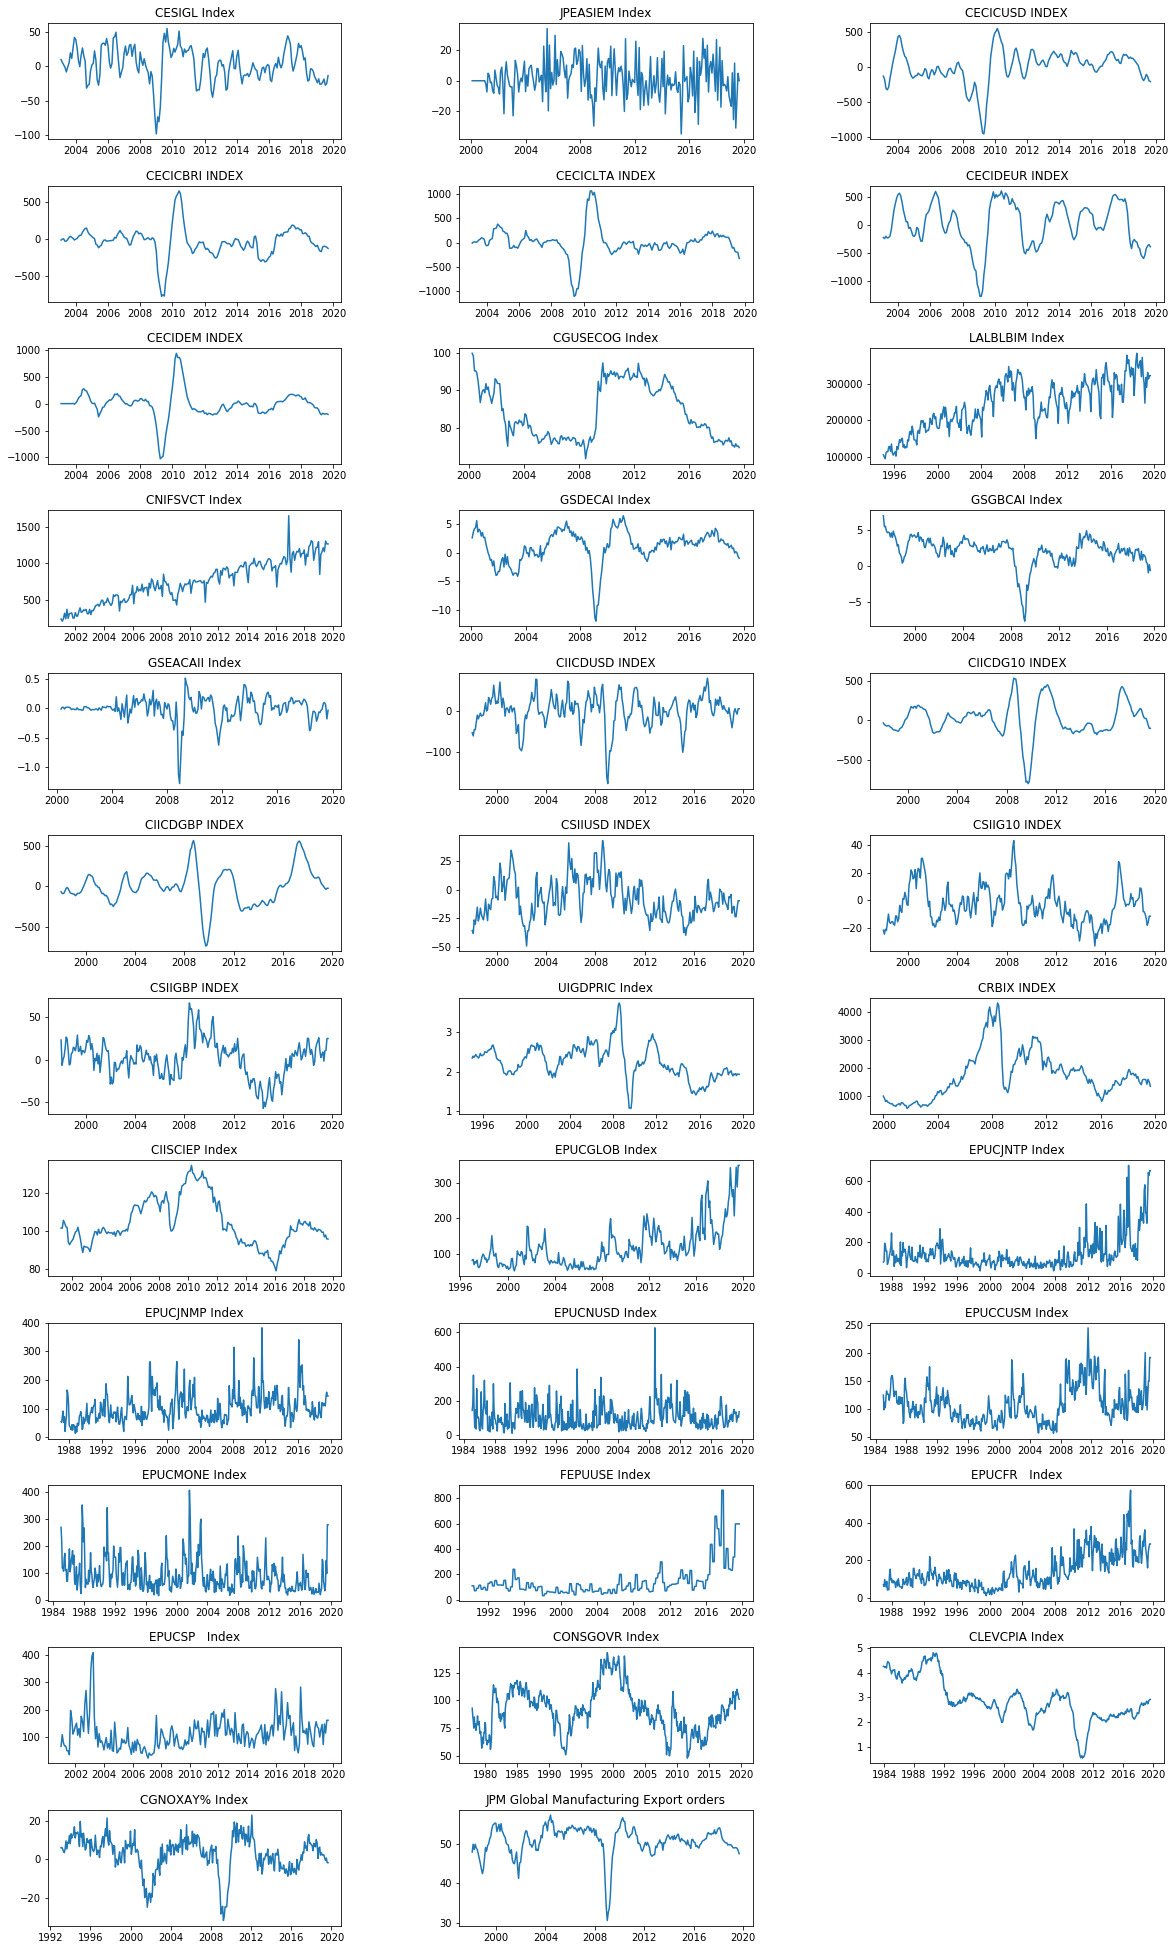

In [11]:
plot_time_series(macro_data, (20,35))

### Sentiment Data

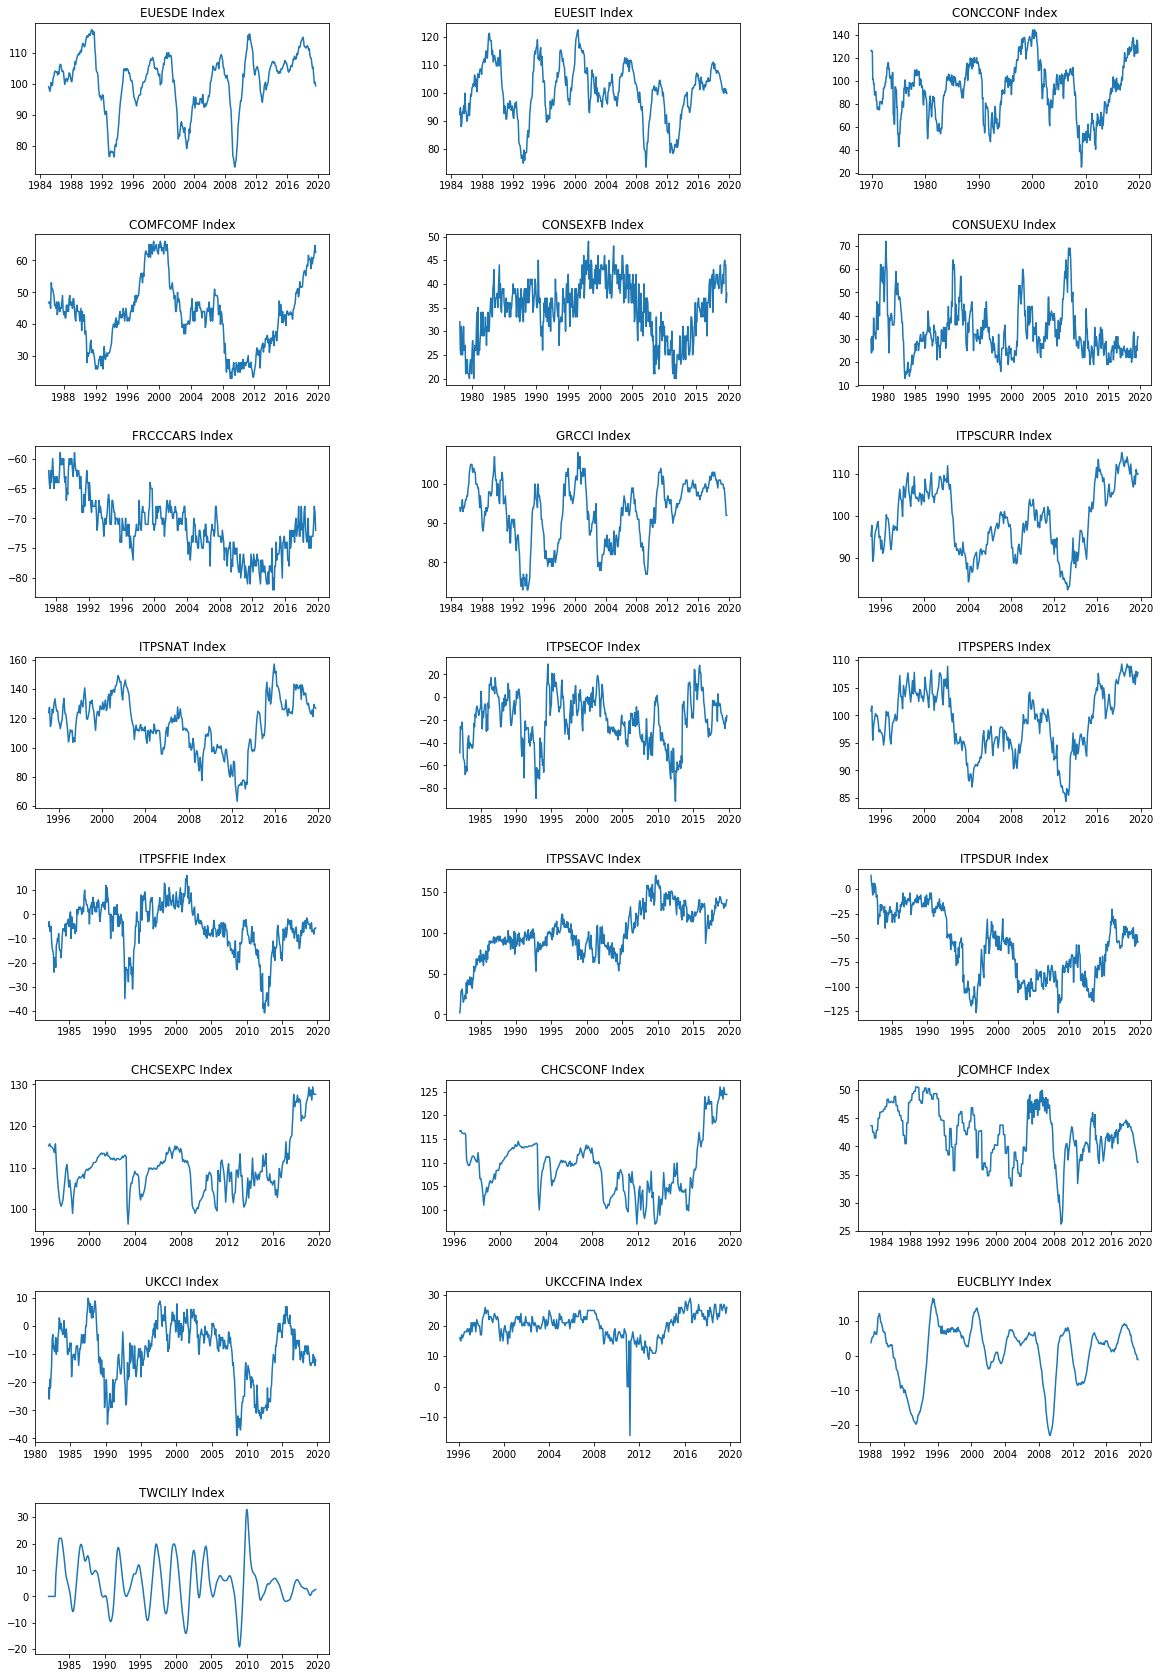

In [12]:
plot_time_series(sentiment_data)

### Market Data

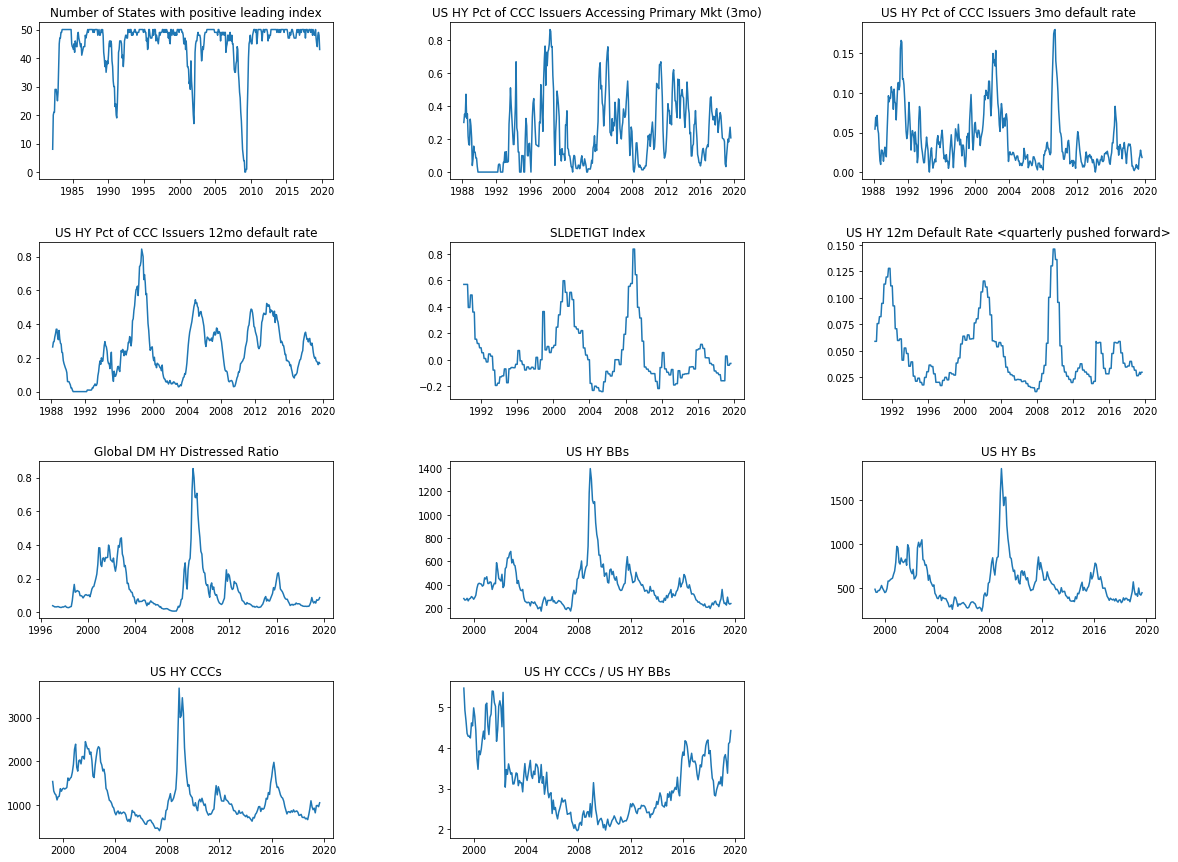

In [13]:
plot_time_series(market_data, (20, 15))

## Compute 1 month and 3 month returns (dependent variables)

In [14]:
# sign_1m = return_data.rolling(2).apply(lambda x: 1 if x[-1] > x[0] else 0, 'raw=True')
sign_1m = return_data.rolling(2).apply(lambda x: x[-1] / x[0] - 1, 'raw=True')
sign_1m.head()

,MSCI EM,SPX 500 Price Return,Eurostoxx 600,MSCI Japan,MSCI World,Russell 2000,Crude Oil Total Return,CRB Metals,Gold Price,S&P GSCI Total Return Index,UST 7-10yr,German 7-10yr,US IG Corps,US HY Corp,US Mortgages
Date,,,,,,,,,,,,,,,
1987-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-29,0.094200,0.039419,0.012658,0.108124,0.022599,0.041702,0.029651,NaN,-0.053914,0.026579,0.036914,0.001829,0.030115,0.018926,0.018761
1988-02-29,0.002376,0.030339,0.047917,0.080618,0.056255,0.087845,-0.047232,NaN,-0.069541,-0.011050,0.006474,0.014682,0.009481,0.018257,0.006300
1988-03-31,0.099927,0.029446,0.008217,0.039814,0.028479,0.045220,0.075621,NaN,0.072275,0.050416,-0.023569,-0.002313,-0.019496,-0.011194,-0.011506
1988-04-29,0.046668,-0.011667,0.031813,0.015756,0.010877,0.021769,0.066258,NaN,-0.017398,0.030992,-0.014052,-0.014949,-0.017430,-0.005582,-0.008991


In [15]:
# sign_3m = return_data.rolling(4).apply(lambda x: 1 if x[-1] > x[0] else 0, 'raw=True')
sign_3m = return_data.rolling(4).apply(lambda x: x[-1] / x[0] - 1, 'raw=True')
sign_3m.head()

,MSCI EM,SPX 500 Price Return,Eurostoxx 600,MSCI Japan,MSCI World,Russell 2000,Crude Oil Total Return,CRB Metals,Gold Price,S&P GSCI Total Return Index,UST 7-10yr,German 7-10yr,US IG Corps,US HY Corp,US Mortgages
Date,,,,,,,,,,,,,,,
1987-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-03-31,0.206400,0.102490,0.069902,0.245134,0.110885,0.184455,0.055203,NaN,-0.056083,0.066419,0.019031,0.014186,0.019608,0.025914,0.013384
1988-04-29,0.153994,0.048303,0.090139,0.141346,0.098152,0.161790,0.092719,NaN,-0.019651,0.071004,-0.031057,-0.002798,-0.027451,0.001238,-0.014221


## Shift index, Merge features and dependent variables

In [20]:
def shift_X_merge_y(X, y, shift_win = 1):
    """
    Shift X matrix by certain window size and merge with y
    @param X: Pandas DataFrame (independent variable)
    @param y: Pandas DataFrame (dependent variable)
    @shift_win: integer (shift window)
    @return: Pandas DataFrame (merge window size)
    """
    # Shift index by given window and transform date to month
    new_X = X.copy()
    new_X.index = new_X.index.shift(shift_win, freq ='M').to_period('M')
    
    # Transform date to month
    new_y = y.copy()
    new_y.index = new_y.index.to_period('M')
    
    # print(len(new_y))
    # print(len(y))
    
    first_index = new_y.index[0]
    merge_X_y = pd.merge(new_X, new_y, on = 'Date', how = 'outer')
    
    # print(len(merge_X_y))
    # print(first_index+len(new_y))
    merge_X_y = merge_X_y.loc[first_index:first_index+len(new_y)-1,:]
    return merge_X_y.iloc[shift_win:]

In [21]:
merge_1month = shift_X_merge_y(merge_tranform, sign_1m)
merge_3month = shift_X_merge_y(merge_tranform, sign_3m, 3)

In [22]:
merge_1month.head()

,CESIGL Index,CESIGL Index 1 month absolute delta,CESIGL Index 2 month absolute delta,CESIGL Index 3 month absolute delta,CESIGL Index 12 month absolute delta,CESIGL Index 2 mo avg,CESIGL Index 3 mo avg,CESIGL Index 6 mo avg,CESIGL Index 6 mo avg - 3 mo avg,JPEASIEM Index,...,Russell 2000,Crude Oil Total Return,CRB Metals,Gold Price,S&P GSCI Total Return Index,UST 7-10yr,German 7-10yr,US IG Corps,US HY Corp,US Mortgages
Date,,,,,,,,,,,,,,,,,,,,,
1988-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.041702,0.029651,NaN,-0.053914,0.026579,0.036914,0.001829,0.030115,0.018926,0.018761
1988-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.087845,-0.047232,NaN,-0.069541,-0.011050,0.006474,0.014682,0.009481,0.018257,0.006300
1988-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045220,0.075621,NaN,0.072275,0.050416,-0.023569,-0.002313,-0.019496,-0.011194,-0.011506
1988-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021769,0.066258,NaN,-0.017398,0.030992,-0.014052,-0.014949,-0.017430,-0.005582,-0.008991
1988-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.028661,-0.027264,NaN,0.014477,0.035317,-0.021125,-0.010720,-0.015731,-0.005740,-0.012413


In [23]:
merge_3month.head()

,CESIGL Index,CESIGL Index 1 month absolute delta,CESIGL Index 2 month absolute delta,CESIGL Index 3 month absolute delta,CESIGL Index 12 month absolute delta,CESIGL Index 2 mo avg,CESIGL Index 3 mo avg,CESIGL Index 6 mo avg,CESIGL Index 6 mo avg - 3 mo avg,JPEASIEM Index,...,Russell 2000,Crude Oil Total Return,CRB Metals,Gold Price,S&P GSCI Total Return Index,UST 7-10yr,German 7-10yr,US IG Corps,US HY Corp,US Mortgages
Date,,,,,,,,,,,,,,,,,,,,,
1988-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.184455,0.055203,NaN,-0.056083,0.066419,0.019031,0.014186,0.019608,0.025914,0.013384
1988-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.161790,0.092719,NaN,-0.019651,0.071004,-0.031057,-0.002798,-0.027451,0.001238,-0.014221
1988-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.037365,0.115621,NaN,0.068872,0.121219,-0.057627,-0.027763,-0.051741,-0.022358,-0.032553
1988-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.061468,-0.101555,NaN,-0.044644,0.037587,-0.013009,-0.026163,-0.014536,-0.000221,-0.012929
1988-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027830,-0.097929,NaN,-0.027171,0.012351,-0.015930,-0.024770,-0.005957,0.006839,-0.011358


In [24]:
len(merge_tranform), len(sign_1m), len(sign_3m)

(601, 381, 381)

In [25]:
len(merge_1month), len(merge_3month)

(380, 378)

In [26]:
merge_1month.tail()

,CESIGL Index,CESIGL Index 1 month absolute delta,CESIGL Index 2 month absolute delta,CESIGL Index 3 month absolute delta,CESIGL Index 12 month absolute delta,CESIGL Index 2 mo avg,CESIGL Index 3 mo avg,CESIGL Index 6 mo avg,CESIGL Index 6 mo avg - 3 mo avg,JPEASIEM Index,...,Russell 2000,Crude Oil Total Return,CRB Metals,Gold Price,S&P GSCI Total Return Index,UST 7-10yr,German 7-10yr,US IG Corps,US HY Corp,US Mortgages
Date,,,,,,,,,,,,,,,,,,,,,
2019-04,-26.2,0.2,-7.7,-1.9,-38.1,-26.30,-23.700000,-21.616667,2.083333,-25.61,...,0.033429,0.064574,-0.005554,-0.006771,0.028493,-0.006570,-0.007061,0.002279,0.008768,-0.002555
2019-05,-23.5,2.7,2.9,-5.0,-13.6,-24.85,-25.366667,-23.000000,2.366667,11.66,...,-0.079012,-0.162883,-0.103002,0.017062,-0.082133,0.027387,0.015061,0.011060,-0.017868,0.013332
2019-06,-18.8,4.7,7.4,7.6,3.0,-21.15,-22.833333,-22.950000,-0.116667,-31.20,...,0.068977,0.090116,0.122389,0.079666,0.044300,-0.229911,0.007819,-0.171147,0.019191,-0.131748
2019-07,-27.7,-8.9,-4.2,-1.5,-7.6,-23.25,-23.333333,-23.516667,-0.183333,-13.27,...,0.005128,0.002242,-0.057352,0.003157,-0.002114,-0.003246,0.009144,0.003361,-0.000091,-0.002656
2019-08,-25.6,2.1,-6.8,-2.1,-21.8,-26.65,-24.033333,-24.700000,-0.666667,4.91,...,-0.050658,-0.056619,-0.103370,0.075253,-0.056230,0.037076,0.017651,0.027180,-0.001267,0.019902


In [27]:
merge_3month.tail()

,CESIGL Index,CESIGL Index 1 month absolute delta,CESIGL Index 2 month absolute delta,CESIGL Index 3 month absolute delta,CESIGL Index 12 month absolute delta,CESIGL Index 2 mo avg,CESIGL Index 3 mo avg,CESIGL Index 6 mo avg,CESIGL Index 6 mo avg - 3 mo avg,JPEASIEM Index,...,Russell 2000,Crude Oil Total Return,CRB Metals,Gold Price,S&P GSCI Total Return Index,UST 7-10yr,German 7-10yr,US IG Corps,US HY Corp,US Mortgages
Date,,,,,,,,,,,,,,,,,,,,,
2019-04,-18.5,5.8,0.6,-3.3,-38.5,-21.40,-20.633333,-14.883333,5.750000,-16.82,...,0.061218,0.179236,0.007318,-0.028497,0.084891,0.010180,0.007369,0.024119,0.024931,0.006707
2019-05,-26.4,-7.9,-2.1,-7.3,-35.5,-22.45,-23.066667,-18.533333,4.533333,5.25,...,-0.069856,-0.067168,-0.108263,-0.005985,-0.040788,0.043811,0.026184,0.035189,-0.004834,0.022398
2019-06,-26.2,0.2,-7.7,-1.9,-38.1,-26.30,-23.700000,-21.616667,2.083333,-25.61,...,0.017427,-0.028518,0.001188,0.090652,-0.014160,-0.214019,0.015774,-0.160070,0.009757,-0.122420
2019-07,-23.5,2.7,2.9,-5.0,-13.6,-24.85,-25.366667,-23.000000,2.366667,11.66,...,-0.010436,-0.085399,-0.050960,0.101554,-0.043498,-0.211389,0.032352,-0.159164,0.000889,-0.122509
2019-08,-18.8,4.7,7.4,7.6,3.0,-21.15,-22.833333,-22.950000,-0.116667,-31.20,...,0.020029,0.030700,-0.051349,0.164579,-0.016505,-0.203952,0.034987,-0.145758,0.017807,-0.116820


## Store the merged data to two csv files

In [28]:
merge_1month.to_csv('merge_1month.csv')
merge_3month.to_csv('merge_3month.csv')

## Feature Selection

In [29]:
def feature_selection_tree_based_model(X, y, tree_model):
    """
    Perform feature selection based on tree based model (random forest, gradient boosting, etc.)
    @param X: Pandas DataFrame (independent variables)
    @param y: Pandas Series (dependent variables)
    @param tree_model: sklearn tree-based model
    @return: list of features
    """
    tree_select = SelectFromModel(tree_model)
    # Need to remove NaN, inf or -inf values before fitting the model
    tree_select.fit(X, y)
    
    selected_featutre = X.columns[(tree_select.get_support())]
    return selected_featutre

def feature_selection_multiple_labels(merge_dataset, dependent_var_list, tree_model):
    """
    Perform feature selection based on tree based model for every dependent variable
    @param merge_dataset: Pandas DataFrame (independent variables and dependent variables)
    @param dependent_var_list: list of dependent variables
    @param tree_model: sklearn tree-based model
    @return: dictionary (response: list of features)
    """    
    feature_summary = dict()
    
    dataset_cleaned = merge_dataset[~merge_dataset.isin([np.nan, np.inf, -np.inf]).any(1)]
    X = dataset_cleaned.loc[:,~dataset_cleaned.columns.isin(dependent_var_list)]
    
    for y in dependent_var_list:
        feature_summary[y] = feature_selection_tree_based_model(X, dataset_cleaned[y], tree_model)
    
    return feature_summary

### Random Forest Feature Selection

In [33]:
rf = RandomForestRegressor(n_estimators = 1000)
rf_1month_feature = feature_selection_multiple_labels(merge_1month, sign_1m, rf)
rf_3month_feature = feature_selection_multiple_labels(merge_3month, sign_3m, rf)

In [34]:
rf_1month_feature

{'MSCI EM': Index(['CESIGL Index', 'CESIGL Index 1 month absolute delta',
        'CESIGL Index 2 month absolute delta',
        'CESIGL Index 3 month absolute delta',
        'CESIGL Index 12 month absolute delta', 'CESIGL Index 2 mo avg',
        'CESIGL Index 3 mo avg', 'CESIGL Index 6 mo avg - 3 mo avg',
        'JPEASIEM Index 1 month absolute delta',
        'JPEASIEM Index 3 month absolute delta',
        ...
        'US HY Bs 2 mo avg', 'US HY Bs 6 mo avg - 3 mo avg',
        'US HY CCCs 1 month absolute delta', 'US HY CCCs 1 month % change',
        'US HY CCCs 2 month absolute delta',
        'US HY CCCs 3 month absolute delta', 'US HY CCCs 3 month % change',
        'US HY CCCs 6 mo avg - 3 mo avg',
        'US HY CCCs / US HY BBs 3 month % change',
        'US HY CCCs / US HY BBs 3 year Z-score'],
       dtype='object', length=221),
 'SPX 500 Price Return': Index(['CECICBRI INDEX 6 mo avg - 3 mo avg',
        'CGUSECOG Index 2 month absolute delta',
        'CGUSECOG Index 

In [35]:
rf_3month_feature

{'MSCI EM': Index(['CESIGL Index', 'CESIGL Index 1 month absolute delta',
        'CESIGL Index 3 month absolute delta',
        'CESIGL Index 12 month absolute delta', 'CESIGL Index 2 mo avg',
        'CESIGL Index 3 mo avg', 'CESIGL Index 6 mo avg - 3 mo avg',
        'JPEASIEM Index 2 month absolute delta',
        'JPEASIEM Index 12 month absolute delta', 'JPEASIEM Index 2 mo avg',
        ...
        'US HY BBs 6 mo avg', 'US HY BBs 6 mo avg - 3 mo avg',
        'US HY Bs 3 mo avg', 'US HY Bs 6 mo avg', 'US HY CCCs 3 mo avg',
        'US HY CCCs 6 mo avg', 'US HY CCCs / US HY BBs 1 month % change',
        'US HY CCCs / US HY BBs 3 month % change',
        'US HY CCCs / US HY BBs 12 month % change',
        'US HY CCCs / US HY BBs 6 mo avg - 3 mo avg'],
       dtype='object', length=175),
 'SPX 500 Price Return': Index(['CESIGL Index 6 mo avg - 3 mo avg', 'CECICUSD INDEX',
        'CECICUSD INDEX 1 month absolute delta',
        'CECICUSD INDEX 2 month absolute delta', 'CECICUSD I

### Gradient Boosting Feature Selection

In [36]:
gbt = GradientBoostingRegressor(n_estimators = 1000)
gbt_1month_feature = feature_selection_multiple_labels(merge_1month, sign_1m, gbt)
gbt_3month_feature = feature_selection_multiple_labels(merge_3month, sign_3m, gbt)

In [37]:
gbt_1month_feature

{'MSCI EM': Index(['CESIGL Index', 'CESIGL Index 1 month absolute delta',
        'CESIGL Index 2 month absolute delta', 'CESIGL Index 2 mo avg',
        'CESIGL Index 3 mo avg', 'CESIGL Index 6 mo avg - 3 mo avg',
        'JPEASIEM Index 1 month absolute delta',
        'JPEASIEM Index 12 month absolute delta', 'JPEASIEM Index 6 mo avg',
        'CECICLTA INDEX 3 mo avg',
        ...
        'US HY BBs 12 month % change', 'US HY Bs',
        'US HY Bs 1 month absolute delta', 'US HY Bs 3 month % change',
        'US HY Bs 12 month % change', 'US HY Bs 12 mo avg',
        'US HY CCCs 1 month absolute delta', 'US HY CCCs 1 month % change',
        'US HY CCCs 2 month absolute delta',
        'US HY CCCs / US HY BBs 3 year Z-score'],
       dtype='object', length=126),
 'SPX 500 Price Return': Index(['JPEASIEM Index 1 month absolute delta',
        'JPEASIEM Index 3 month absolute delta', 'CECICUSD INDEX',
        'CECICUSD INDEX 2 month absolute delta',
        'CECICBRI INDEX 2 month a

In [38]:
gbt_3month_feature

{'MSCI EM': Index(['CESIGL Index', 'CESIGL Index 12 month absolute delta',
        'CESIGL Index 2 mo avg', 'CESIGL Index 3 mo avg',
        'CESIGL Index 6 mo avg', 'CESIGL Index 6 mo avg - 3 mo avg',
        'JPEASIEM Index 12 month absolute delta', 'JPEASIEM Index 3 mo avg',
        'CECICBRI INDEX', 'CECICBRI INDEX 3 month absolute delta',
        ...
        'US HY 12m Default Rate <quarterly pushed forward> 3 month absolute delta',
        'US HY BBs', 'US HY BBs 12 mo avg', 'US HY Bs 1 month absolute delta',
        'US HY Bs 6 mo avg - 3 mo avg', 'US HY CCCs 1 month absolute delta',
        'US HY CCCs 12 month absolute delta', 'US HY CCCs 6 mo avg',
        'US HY CCCs / US HY BBs 3 mo avg',
        'US HY CCCs / US HY BBs 6 mo avg - 3 mo avg'],
       dtype='object', length=107),
 'SPX 500 Price Return': Index(['CESIGL Index 6 mo avg - 3 mo avg', 'JPEASIEM Index', 'CECICUSD INDEX',
        'CECICUSD INDEX 2 month absolute delta', 'CECICUSD INDEX 6 mo avg',
        'CGUSECOG I